This post is part of a series documenting my (meager) contributions to an [investigation](https://www.nasa.gov/feature/goddard/2017/nasa-scientist-studies-whether-solar-storms-cause-animal-beachings) to uncover relations, if any, between space weather marine mammal beaching. This first installment is a warm-up, where I explore a small part of marine mammal beaching time series recorded in the vicinity of Cape Cod, Massachusetts (USA).
<!-- TEASER_END -->

In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as pl
import seaborn as sb
import matplotlib.colors as mcolors
from calendar import month_name
import numpy as np
import warnings
from IPython.display import Image
import pymc3 as pm
%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')

### LOAD & CLEAN

In [3]:
from matplotlib import rcParams

rcParams['xtick.labelsize']=14
rcParams['ytick.labelsize']=14
rcParams['font.size']=16

In [4]:
fp = '/home/madhatter106/DATA/Beaching_Project/IFAW Mass Stranding Data 1999-2014.xlsx'
try:
    df = pd.read_excel(fp)
except FileNotFoundError as e:
    print(e)

In [5]:
df.columns

Index(['MASS_STRAND_NUM', 'SERIES_NUM', 'Event Start Date',
       'Event End date (if applicable)', 'COMMENTS',
       'Number of Animals Stranded', 'Number of Additional Animals Herded',
       'LATITUDE_DEGREE', 'LONGITUDE_DEGREE', 'Addn. LATITUDE_DEGREE ',
       'Addm. LONGITUDE_DEGREE', 'SPECIES'],
      dtype='object')

In [6]:
df.head(2)

,MASS_STRAND_NUM,SERIES_NUM,Event Start Date,Event End date (if applicable),COMMENTS,Number of Animals Stranded,Number of Additional Animals Herded,LATITUDE_DEGREE,LONGITUDE_DEGREE,Addn. LATITUDE_DEGREE,Addm. LONGITUDE_DEGREE,SPECIES
0,MS00-01,Series0003,2000-04-09,NaN,Collected level A data\n\nCattle ear tag white...,2.0,0.0,41.930667,70.069667,NaN,NaN,Lagenorhynchus acutus
1,MS00-02,Series0003,2000-04-11,NaN,"Skin- Kim Amaral, Dorsal fin to G. Early\n\nS...",2.0,0.0,41.933333,70.024167,NaN,NaN,Lagenorhynchus acutus


Cleanup: too many non-features (useless columns), I'll start by dropping those. There are several lines for a given event, and at this point I want to use only the line that has the numbers stranding and herded numbers. I also care about numbers of stranded/herded animals, location, date, species. But before, let's get some stats on the whole set...

In [7]:
df.describe()

,Event End date (if applicable),Number of Animals Stranded,Number of Additional Animals Herded,LATITUDE_DEGREE,LONGITUDE_DEGREE,Addn. LATITUDE_DEGREE,Addm. LONGITUDE_DEGREE
count,0.0,160.00000,157.000000,2.310000e+02,2.310000e+02,2.040000e+02,2.040000e+02
mean,NaN,5.70625,0.242038,1.812812e+04,3.034970e+04,2.052188e+04,3.435730e+04
std,NaN,6.34203,1.885849,2.748874e+05,4.608534e+05,2.925134e+05,4.904041e+05
min,NaN,1.00000,0.000000,4.142633e+01,-7.047960e+01,4.142633e+01,-7.047960e+01
25%,NaN,2.00000,0.000000,4.177622e+01,-7.000550e+01,4.177515e+01,-7.001266e+01
50%,NaN,4.00000,0.000000,4.189230e+01,7.002337e+01,4.187768e+01,7.001643e+01
75%,NaN,6.00000,0.000000,4.192809e+01,7.006647e+01,4.192696e+01,7.006717e+01
max,NaN,56.00000,20.000000,4.177969e+06,7.004393e+06,4.177969e+06,7.004393e+06


160 data for stranded. and 157 data for herded. For now I'll also ditch Addn. Lat/Lon. This is not final however, and I might still reincorporate that data once again, if I feel the need.

In [8]:
df.drop(['MASS_STRAND_NUM','SERIES_NUM','Event End date (if applicable)','COMMENTS','Addn. LATITUDE_DEGREE ',
         'Addm. LONGITUDE_DEGREE'],axis=1, inplace=True)

Next is to replace column names with something more practical:

In [9]:
replNames = {key: repl for key,repl in zip(df.columns[:3],['date','stranded', 'herded'])}
replNames.update({key:key.lower().split('_')[0] for key in df.columns[3:]})
df.rename(columns=replNames,inplace=True)
df.head(5)

,date,stranded,herded,latitude,longitude,species
0,2000-04-09,2.0,0.0,41.930667,70.069667,Lagenorhynchus acutus
1,2000-04-11,2.0,0.0,41.933333,70.024167,Lagenorhynchus acutus
2,2000-04-11,2.0,0.0,41.933333,70.024167,Lagenorhynchus acutus
3,2000-08-14,NaN,NaN,41.806833,70.002667,Lagenorhynchus acutus
4,2000-08-26,6.0,20.0,41.928167,70.066833,Lagenorhynchus acutus


Let's take a look at what's left in the table

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 6 columns):
date         231 non-null datetime64[ns]
stranded     160 non-null float64
herded       157 non-null float64
latitude     231 non-null float64
longitude    231 non-null float64
species      231 non-null object
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 10.9+ KB


***Cleaning NaNs***

In [11]:
df.loc[(df.stranded.isnull()) & (df.herded.isnull())]

,date,stranded,herded,latitude,longitude,species
3,2000-08-14,NaN,NaN,4.180683e+01,7.000267e+01,Lagenorhynchus acutus
11,2002-03-24,NaN,NaN,4.192347e+01,7.003273e+01,Lagenorhynchus acutus
25,2004-12-30,NaN,NaN,4.182300e+01,7.000443e+01,Lagenorhynchus acutus
34,2005-12-10,NaN,NaN,4.142633e+01,7.028300e+01,Delphinus delphis
35,2005-12-10,NaN,NaN,4.171000e+01,7.032317e+01,Delphinus delphis
36,2005-12-10,NaN,NaN,4.171133e+01,7.027467e+01,Delphinus delphis
37,2005-12-10,NaN,NaN,4.178635e+01,7.002950e+01,Globicephala melas
38,2005-12-10,NaN,NaN,4.176835e+01,7.009107e+01,Globicephala melas
39,2005-12-10,NaN,NaN,4.171017e+01,7.028802e+01,Delphinus delphis
40,2005-12-10,NaN,NaN,4.174863e+01,7.019983e+01,Globicephala melas


In [12]:
df.loc[(df.stranded.isnull()) & (np.isfinite(df.herded))]

,date,stranded,herded,latitude,longitude,species
113,2009-12-07,NaN,0.0,41.792267,70.0197,Delphinus delphis


In [13]:
df.loc[(np.isfinite(df.stranded)) &(df.herded.isnull())]

,date,stranded,herded,latitude,longitude,species
98,2007-08-23,2.0,NaN,41.595333,70.847333,Stenella coeruleoalba
112,2009-12-07,3.0,NaN,41.775783,70.055300,Delphinus delphis
174,2012-01-19,6.0,NaN,41.928016,70.069959,Delphinus delphis
225,1999-03-20,12.0,NaN,41.916167,70.062333,Lagenorhynchus acutus


So looks like we're fine if we dropped rows where the column "stranded" is NaN. and replace the remaining herded Nans with '0'

In [14]:
df.dropna(subset=['stranded'], inplace=True)

In [15]:
df.loc[df.herded.isnull(),'herded'] = 0

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 230
Data columns (total 6 columns):
date         160 non-null datetime64[ns]
stranded     160 non-null float64
herded       160 non-null float64
latitude     160 non-null float64
longitude    160 non-null float64
species      160 non-null object
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 8.8+ KB


*** More cleaning: Duplicates***

Duplicate values might either indicate a problem in data organization, or an actual case of multiple entries of the same data. They could also have a nefarious effect on subsequent analyses. So I'll next look for those.

In [17]:
df.loc[df.duplicated(),:]

,date,stranded,herded,latitude,longitude,species
2,2000-04-11,2.0,0.0,41.933333,70.024167,Lagenorhynchus acutus


There appear to be a duplicate entry of the above, and there's a decision needs to be made here. Was the twin entry a legitimate or an error? Examining the original excel file, it looks to me like a redundant entry. I will drop one

In [18]:
df.drop_duplicates(inplace=True)

Now, there might still be some date duplicates, because of multiple events ocurring on the same day. Let's look at that: Date-wise duplicates

In [19]:
df.loc[df.duplicated(subset='date')]

,date,stranded,herded,latitude,longitude,species
103,2008-12-25,3.0,0.0,41.9205,70.032167,Grampus griseus
187,2012-02-09,3.0,0.0,41.8923,-70.008500,Delphinus delphis


Two cases. Let's see what happens on those dates:

In [20]:
dupDates = df.loc[df.duplicated(subset='date'),'date'].values
for dd in dupDates:
    print(df[df['date'] == dd])

          date  stranded  herded  latitude  longitude            species
102 2008-12-25       5.0     0.0   41.7840 -70.033100  Delphinus delphis
103 2008-12-25       3.0     0.0   41.9205  70.032167    Grampus griseus
          date  stranded  herded  latitude  longitude            species
186 2012-02-09       5.0     0.0   41.7272   -70.3031  Delphinus delphis
187 2012-02-09       3.0     0.0   41.8923   -70.0085  Delphinus delphis


So in the first case two different species stranded at different locations. In the second case, the same species stranded at different locations. This might warrant "melting" the data frame (see further below).
That's all the cleaning for now.
Next, I'm going to add a couple of columns. One, day of week, is to help remove observer bias. The second, month of year, is to help reduce noise and bin data toward seasonality. 

In [21]:
df['weekday'] = df.date.dt.weekday_name

In [22]:
df['month'] = df.date.dt.month

Let's see what that did

In [23]:
df.head()

,date,stranded,herded,latitude,longitude,species,weekday,month
0,2000-04-09,2.0,0.0,41.930667,70.069667,Lagenorhynchus acutus,Sunday,4
1,2000-04-11,2.0,0.0,41.933333,70.024167,Lagenorhynchus acutus,Tuesday,4
4,2000-08-26,6.0,20.0,41.928167,70.066833,Lagenorhynchus acutus,Saturday,8
5,2000-08-27,5.0,0.0,41.928967,70.052300,Lagenorhynchus acutus,Sunday,8
6,2001-03-07,2.0,0.0,41.906433,70.001117,Lagenorhynchus acutus,Wednesday,3


Now, to take advantage of Pandas time series functionality, I'm going to assign 'date' as index. Doesn't look like multiple entries on the same date will be a problem.

In [24]:
df.index = df.date
df.drop('date', axis=1, inplace=True)

In [25]:
df.sort_index(inplace=True)

In [26]:
df.head(2)

,stranded,herded,latitude,longitude,species,weekday,month
date,,,,,,,
1999-03-07,6.0,0.0,41.916667,70.033333,Lagenorhynchus acutus,Sunday,3
1999-03-18,5.0,0.0,41.718017,70.368650,Lagenorhynchus acutus,Thursday,3


---
### EXPLORATION & DATA ENGINEERING

Now I can do some preliminary analysis. First I'll look at stranding and herding, breaking it down by species. I'll also take a look at possible weekday bias, and seasonal bias.

*** Observer Bias ***

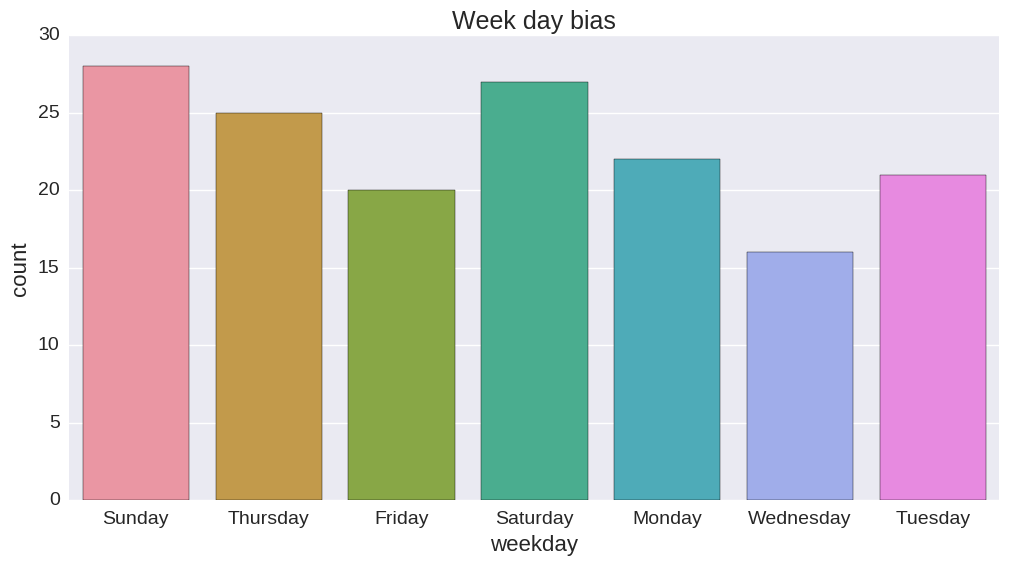

In [27]:
f,ax=pl.subplots(figsize=(12,6))
sb.countplot(x='weekday', data=df,ax=ax);
ax.set_xlabel('weekday', fontsize=16)
ax.set_ylabel('count', fontsize=16);
ax.set_title('Week day bias', fontsize=18);

Numbers are higher during the weekend, but not by a huge margin. It does argue for binning the data to a week or more, maybe even a month. I'll look at seasonal bias, e.g. by aggregating on a month scale.

***

***Seasonal Bias***

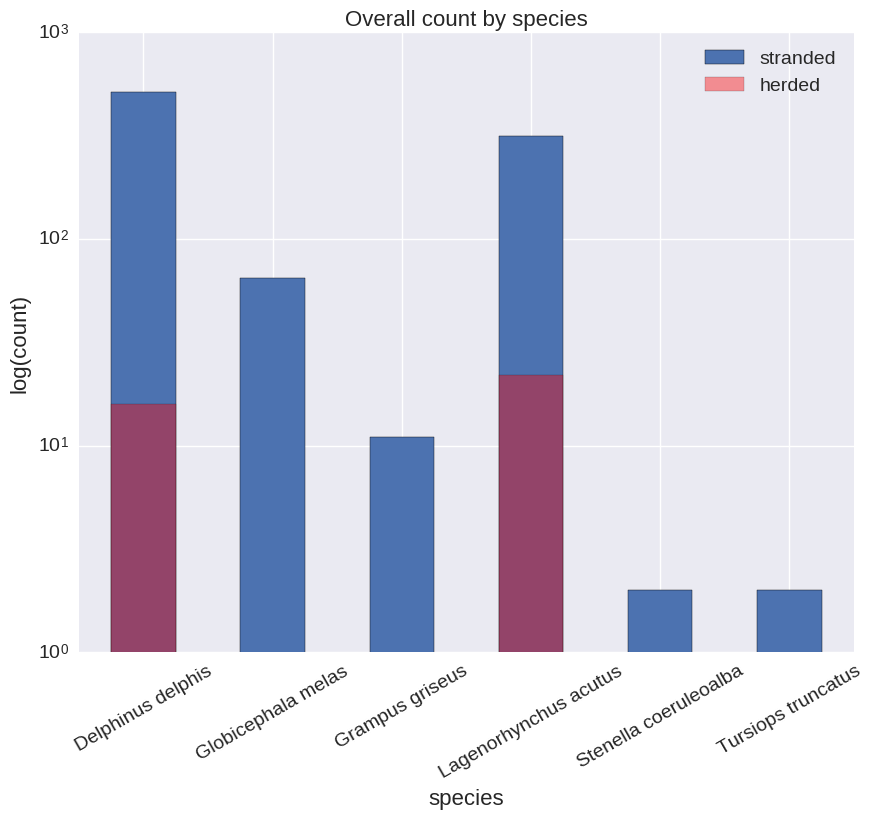

In [28]:
dfs = df.groupby(['species'])['stranded'].sum()
dfh = df.groupby(['species'])['herded'].sum()
f,ax=pl.subplots(figsize=(10,8))
dfs.plot(kind='bar', logy=True,ax=ax, label='stranded')
dfh.plot(kind='bar', logy=True, ax=ax, alpha=0.4, color='red', label='herded')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, fontsize=14)
ax.set_xlabel('species',fontsize=16)
ax.set_ylabel('log(count)', fontsize=16)
ax.set_title('Overall count by species', fontsize=16);
ax.legend(fontsize=14);

In [29]:
dfpivot = df.pivot_table(index='month',columns='species',values='stranded',
                        aggfunc=sum, fill_value=0)

In [30]:
dfMonthly = df.loc[:,['stranded','herded']].resample('M').apply(sum).replace('NaN',0)

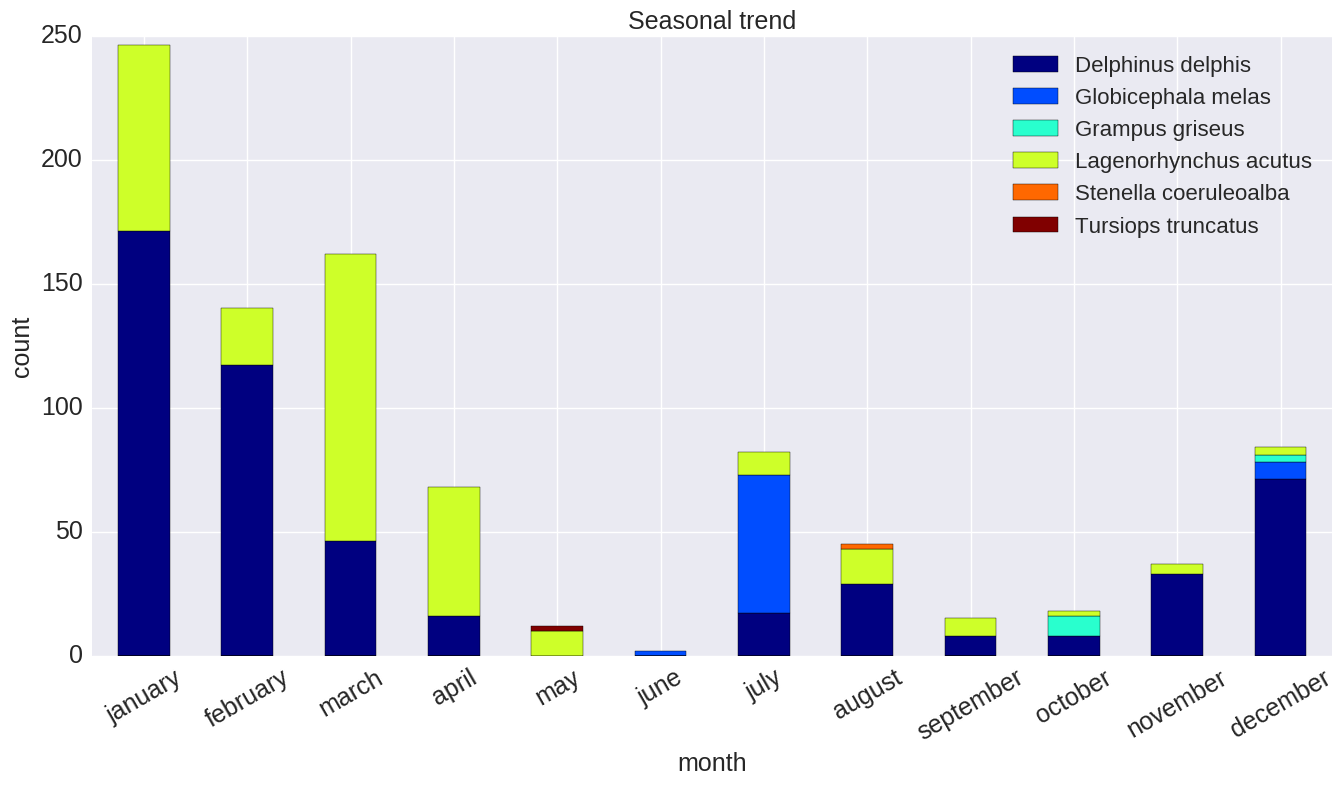

In [31]:
f,ax=pl.subplots(figsize=(16,8))
dfpivot.plot(kind='bar',ax=ax, stacked=True, fontsize=18, colormap='jet')
ax.set_xlabel('month', fontsize=18)
ax.set_ylabel('count', fontsize=18)
ax.set_title('Seasonal trend', fontsize=18);
ax.set_xticklabels([month_name[i].lower() for i in range(1,13)], rotation=30);
ax.legend(fontsize=16);

***Next...***
If I end up modeling the time series, I'll have to come back and zero-pad the data. For now I need to reshape the data some to ease plotting and further exploration. For that, I'll create a new dataframe with the following operations:
1. use one-hot encoding to create count columns for each species.
2. sum *stranded* and *herded* into a new *total* columns
3. multiply the total count across species count columns
4. rename species columns to a more practical set of names.

In [32]:
#1.
dfs = pd.get_dummies(df, columns=['species'])
#2.
dfs['total']=dfs[['stranded','herded']].sum(axis=1)
#3.
speciescols = [col for col in dfs.columns if 'species' in col]
dfs[speciescols] = dfs[speciescols].multiply(dfs.total, axis=0)
#4.
dfs.rename(columns={key:key.split('_')[1].replace(' ','_') for key in speciescols},
           inplace=True)
# Let's verify the result is as desired...
dfs.head(10)

,stranded,herded,latitude,longitude,weekday,month,Delphinus_delphis,Globicephala_melas,Grampus_griseus,Lagenorhynchus_acutus,Stenella_coeruleoalba,Tursiops_truncatus,total
date,,,,,,,,,,,,,
1999-03-07,6.0,0.0,41.916667,70.033333,Sunday,3,0.0,0.0,0.0,6.0,0.0,0.0,6.0
1999-03-18,5.0,0.0,41.718017,70.368650,Thursday,3,0.0,0.0,0.0,5.0,0.0,0.0,5.0
1999-03-19,29.0,0.0,41.933900,70.016200,Friday,3,0.0,0.0,0.0,29.0,0.0,0.0,29.0
1999-03-20,12.0,0.0,41.916167,70.062333,Saturday,3,0.0,0.0,0.0,12.0,0.0,0.0,12.0
1999-03-21,2.0,0.0,41.933900,70.016200,Sunday,3,0.0,0.0,0.0,2.0,0.0,0.0,2.0
1999-03-22,2.0,0.0,41.939333,70.054833,Monday,3,0.0,0.0,0.0,2.0,0.0,0.0,2.0
1999-06-27,2.0,0.0,41.663667,69.990667,Sunday,6,0.0,2.0,0.0,0.0,0.0,0.0,2.0
1999-12-15,3.0,0.0,41.761867,70.113483,Wednesday,12,3.0,0.0,0.0,0.0,0.0,0.0,3.0
2000-04-09,2.0,0.0,41.930667,70.069667,Sunday,4,0.0,0.0,0.0,2.0,0.0,0.0,2.0


What about the multi-species event we detected earlier? Now that the dataframe is date-indexed, it's easy to check:

In [33]:
dfs.loc['2008-12-25',:]

,stranded,herded,latitude,longitude,weekday,month,Delphinus_delphis,Globicephala_melas,Grampus_griseus,Lagenorhynchus_acutus,Stenella_coeruleoalba,Tursiops_truncatus,total
date,,,,,,,,,,,,,
2008-12-25,5.0,0.0,41.7840,-70.033100,Thursday,12,5.0,0.0,0.0,0.0,0.0,0.0,5.0
2008-12-25,3.0,0.0,41.9205,70.032167,Thursday,12,0.0,0.0,3.0,0.0,0.0,0.0,3.0


For our purpose we don't need lat/lon (always same location) nor weekday (we've already determined there's an intra-week bias) so we'll drop those...

In [34]:
dfs.drop(['latitude','longitude','weekday'],axis=1, inplace=True)

In [35]:
dfs_monthly = dfs.resample('M',level=0).apply(sum).replace('NaN',0.0)

In [36]:
speciescols = [col for col in dfs_monthly.columns if '_' in col]

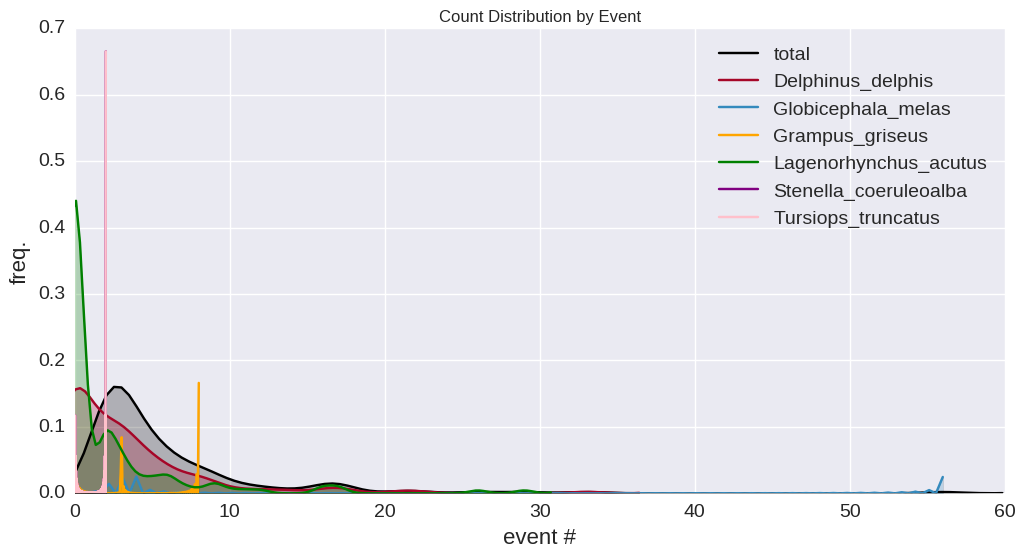

In [37]:
f, ax = pl.subplots(figsize=(12,6))
colors = ["#A60628", "#348ABD", 'orange','green','purple','pink']
ax.set_title('Count Distribution by Event')
sb.kdeplot(dfs.total,shade=True,ax=ax,color='k')
for col, spec in zip(colors, speciescols):
    sb.kdeplot(dfs[spec], shade=True, ax=ax, color=col)
ax.legend(fontsize=14)
ax.set_xlim((0, 60))
ax.set_xlabel('event #', fontsize=16)
ax.set_ylabel('freq.', fontsize=16);

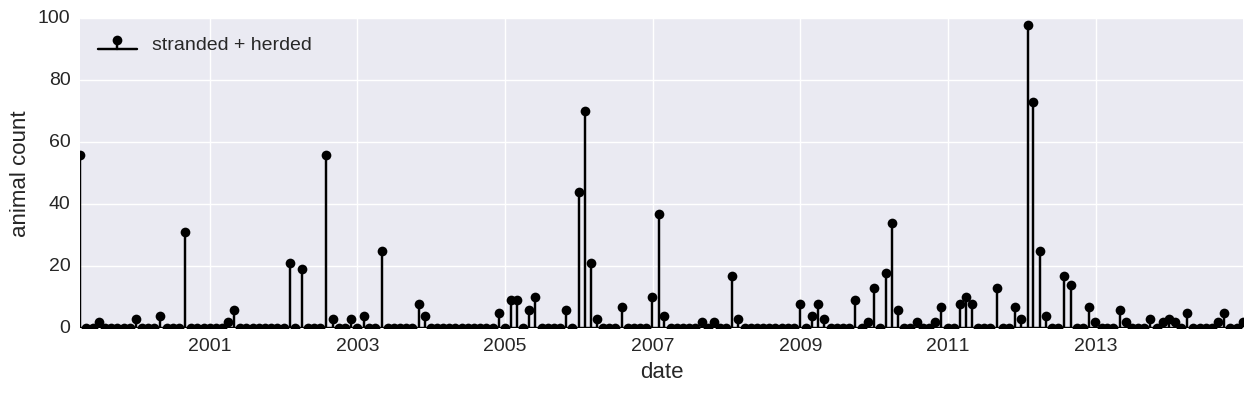

In [38]:
f,ax=pl.subplots(figsize=(15,4))
markerline, stemlines, baseline = ax.stem(dfs_monthly.index.values, dfs_monthly.total.values,
                                          label='stranded + herded')
pl.setp(markerline, 'color','k')
pl.setp(stemlines, 'color', 'k')
pl.setp(baseline, 'color', 'k')
ax.xaxis_date()
ax.legend(loc='best', fontsize=14)
ax.set_xlabel('date', fontsize=16)
ax.set_ylabel('animal count',fontsize=16);

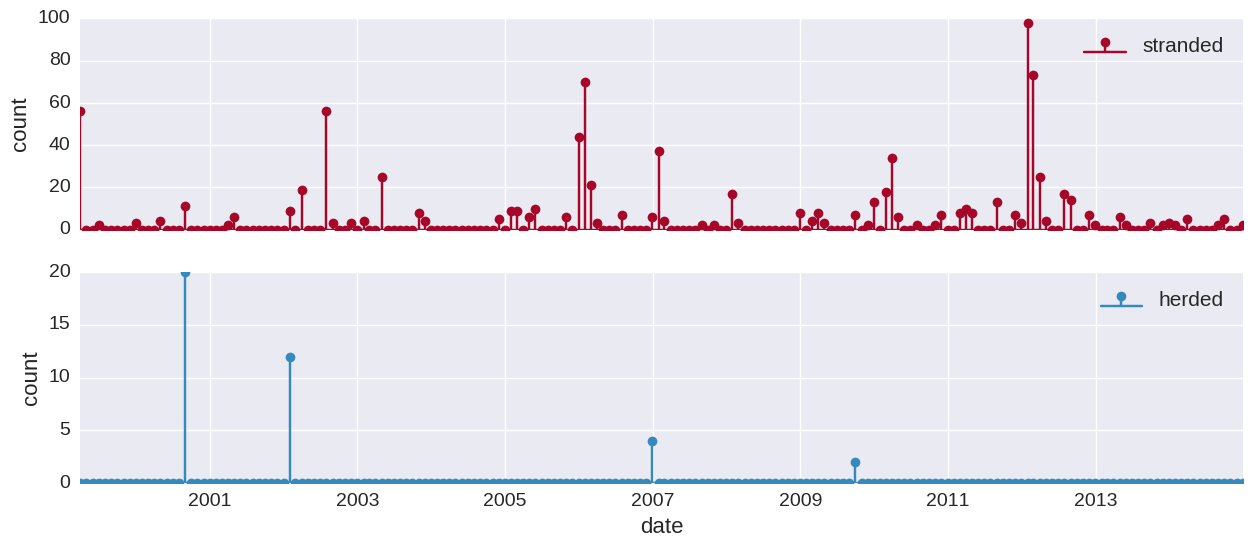

In [39]:
f,axs = pl.subplots(nrows=2,figsize=(15,6), sharex=True)
for ax,col,clr in zip(axs,['stranded','herded'],['#A60628','#348ABD']):
    markerline, stemlines, baseline = ax.stem(dfs_monthly.index.values, dfs_monthly.loc[:,col].values, label=col)
    pl.setp(baseline, 'color', clr)
    pl.setp(stemlines, 'color', clr)
    pl.setp(markerline, 'color',clr)
    ax.xaxis_date()
    ax.legend(loc='best', fontsize=15)
    ax.set_ylabel('count', fontsize=16)
ax.set_xlabel('date', fontsize=16);

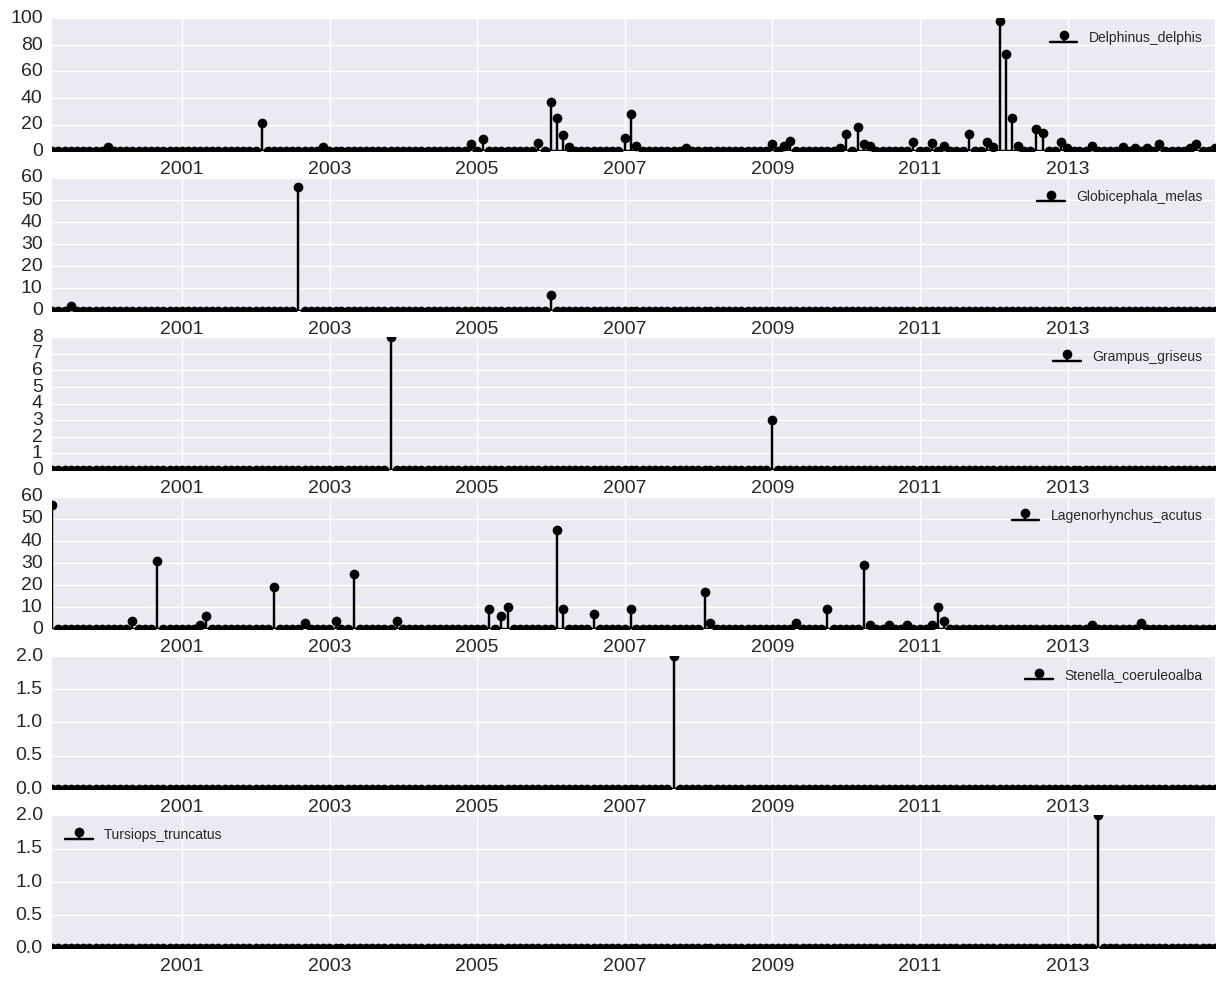

In [40]:
f,axs = pl.subplots(nrows=6,figsize=(15,12))
for ax,col in zip(axs,speciescols):
    markerline, stemlines, baseline = ax.stem(dfs_monthly.index.values, dfs_monthly.loc[:,col].values, label=col)
    pl.setp(markerline, 'color', 'k')
    pl.setp(stemlines, 'color', 'k')
    pl.setp(baseline, 'color', 'k')
    ax.xaxis_date()
    ax.legend(loc='best')

Since these are count data, I am going first to attempt modeling these using a Poisson distribution (*cf*. Modeling section below).  Before moving on, I'm going to pickle the various dataframes created so I can reload them in a subsequent notebook...

In [41]:
dataSaveDir = '/home/madhatter106/DATA/Beaching_Project/'
df.to_pickle(os.path.join(dataSaveDir, 'dfBeaching.pkl'))
dfMonthly.to_pickle(os.path.join(dataSaveDir, 'dfBeachingMonthly.pkl'))
dfs.to_pickle(os.path.join(dataSaveDir, 'dfsBeaching.pkl'))
dfpivot.to_pickle(os.path.join(dataSaveDir, 'dfBchngPivotByMonth.pkl'))
dfs_monthly.to_pickle(os.path.join(dataSaveDir, 'dfsMonthly.pkl'))

... and to store a quick explanation in a text file

In [42]:
expList = [['df', 'main dataframe'], ['dfMonthly', 'df monthly resampling (by sum)'],
            ['dfs', 'main grouped by species'], ['dfpivot', 'pivot by month on stranded & species'],
            ['dfs_monthly', 'dfs montly resampling (by sum)']]
with open(os.path.join(dataSaveDir,'dfExplain.txt'), 'w') as fExplain:
    for pair in expList:
        print("%s: %s" %(pair[0], pair[1]), file=fExplain)

---
### MODELING

These are count data so as mentioned earlier, my first attempt will be to use a Poisson process. Starting from a basic model, I will move on to explore possible switchpoints in the rate at which these beachings occur. A simpler alternative might be to use a binary outcome model (beaching/no beaching) using a Bernoulli process, but for now a boy will dream.

Since I'm of the opinion that frequentist methods and science don't mix (sorry Antti), and because I can't pass up a chance to flex my bayesian muscle, I'll use a very nice library, [pymc3](https://pymc-devs.github.io/pymc3/index.html) for this modeling bit. <img src=https://imgs.xkcd.com/comics/frequentists_vs_bayesians.png width="400" height="800" /img>

                                                                        (XKCD)

I'm going first to assume a single beaching rate for three groups; total count, *D. delphis*,  and *L. acutus*. The other species make too scant an appearance in the data. I'll then attempt to identify switchpoints in time around which significant rates in beaching occur.
The basic inference model follows the diagram displayed below. The observations used are drawn from the dfs dataframe I created in the Exploration & Data Engineering section. The rate parameter is a continuous variable. As I show in the *"Kruscke" diagrams* below, I have two possible distributions I could draw from as priors to the rate parameter; a uniform distribution and an Exponential distribution. <img src="files/count_model.png" width="600" height="1200" /img>

#### 1 - Uniform rate prior

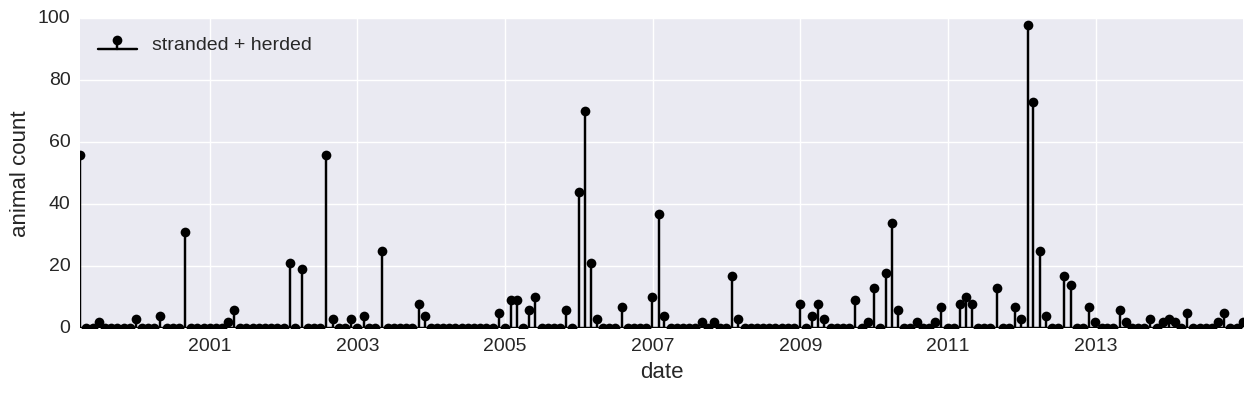

In [43]:
f,ax=pl.subplots(figsize=(15,4))
markerline, stemlines, baseline = ax.stem(dfs_monthly.index.values, dfs_monthly.total.values,
                                          label='stranded + herded')
pl.setp(markerline, 'color','k')
pl.setp(stemlines, 'color', 'k')
pl.setp(baseline, 'color', 'k')
ax.xaxis_date()
ax.legend(loc='best', fontsize=14)
ax.set_xlabel('date', fontsize=16)
ax.set_ylabel('animal count',fontsize=16);

In [44]:
totCntData = dfs_monthly.total.values

Next is to specify the bayesian model. In reference to the Kruschke diagram above

In [45]:
with pm.Model() as totCntMdl:
    # prior
    lmbda = pm.Uniform('lmbda', totCntData.min(), totCntData.max())
    # likelihood
    lklhd = pm.Poisson('likelihood',mu=lmbda, observed=totCntData)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10000, start=start, step=step)

Optimization terminated successfully.
         Current function value: 1672.059521
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9


100%|██████████| 10000/10000 [00:01<00:00, 7763.28it/s]


In [46]:
chain_tcm = trace[1000:]

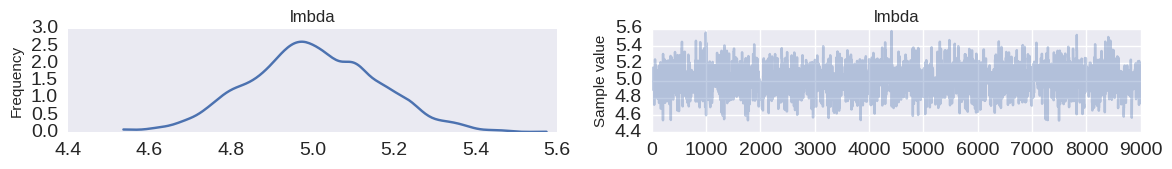

In [47]:
pm.traceplot(chain_tcm);

**MCMC diagnostics**

In [48]:
pm.df_summary(chain_tcm)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
lmbda,4.999995,0.158614,0.003628,4.67588,5.296134


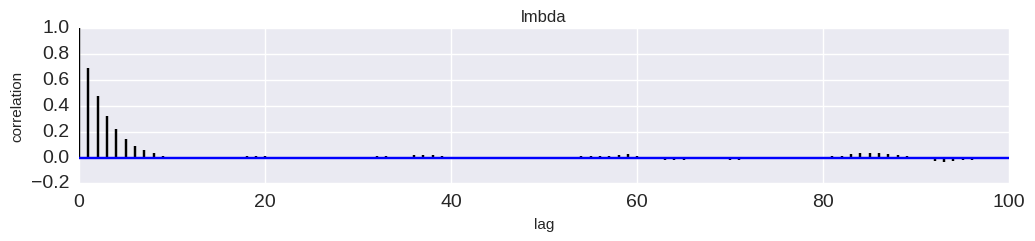

In [49]:
pm.autocorrplot(chain_tcm);

This suggest an average number of strandings of 5 strandings/month, which is just about equal to just taking the mean (4.995). While this may seem like a trivial exercise, I've established that I've set my model right, and in the process I've quantified uncertainty around that number.
Diagnostics above look good, with a relatively small error and a tight 95% credible interval between 4.7 and 5.33, and a quickly subsiding autocorrelation pattern.
I'm going to repeat the exercise with an exponential prior, which receives a hyperprior in the form of an alpha parameter pegged to the sample mean (see model specification).

**2 - exponential prior**

In [50]:
with pm.Model() as totCntMdl_2:
    # prior
    alpha = 1/totCntData.mean()
    lmbda = pm.Exponential('lmbda', alpha)
    # likelihood
    lklhd = pm.Poisson('likelihood',mu=lmbda, observed=totCntData)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace_2 = pm.sample(10000, start=start, step=step)

Optimization terminated successfully.
         Current function value: 1670.031098
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7


100%|██████████| 10000/10000 [00:01<00:00, 7724.43it/s]


In [51]:
chain_tcm_2 = trace_2[1000:]

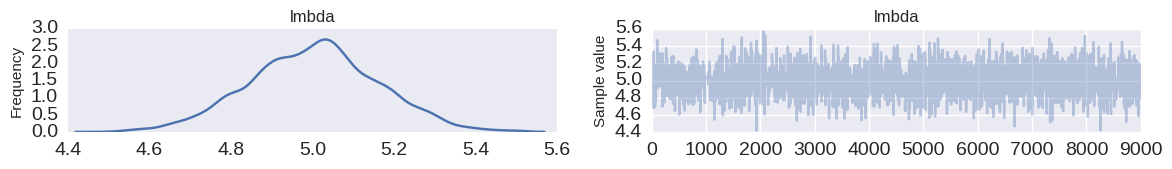

In [52]:
pm.traceplot(chain_tcm_2);

In [53]:
pm.df_summary(chain_tcm_2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
lmbda,5.001957,0.161008,0.003696,4.692926,5.31833


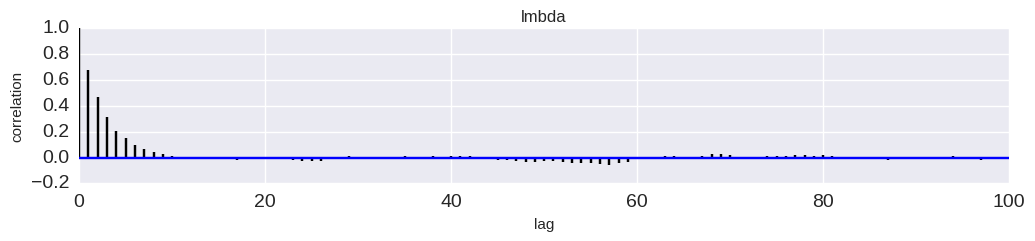

In [54]:
pm.autocorrplot(chain_tcm_2);

#### 3 - switchpoints
Since I get comparable results whether I use a uniform or exponential prior, I'll go ahead with the latter. To search for a switchpoint, I'll add a second lambda parameter for the poisson process and I will introduce a switchpoint, $\tau$ (tau in the model) around which the model can switch lamba parameters to better accomodate a change in stranding rate. The $\tau$ parameter is drawn from a uniform distribution between 0 and the number of months available in the time series.

In [55]:
with pm.Model() as model:
    alpha = 1.0/totCntData.mean()
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=totCntData.size-1)
    idx = np.arange(totCntData.size)
    lambda_ = pm.math.switch( tau >= idx, lambda_1, lambda_2 )
    lklhd = pm.Poisson("lklhd", lambda_, observed=totCntData)
    #step = pm.Metropolis(model.free_RVs)
    traceExpPr = pm.sample(10000, tune=1000)

Assigned NUTS to lambda_1_log_
Assigned NUTS to lambda_2_log_
Assigned Metropolis to tau
100%|██████████| 10000/10000 [00:10<00:00, 995.60it/s]


In [56]:
chainExpPr=traceExpPr[1000:]

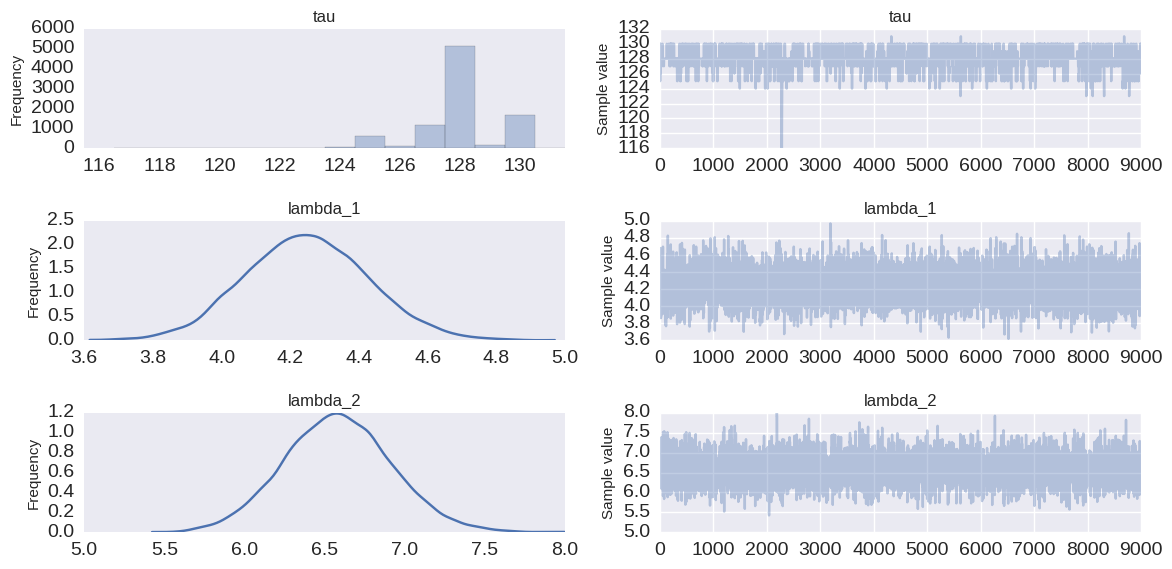

In [57]:
pm.traceplot(chainExpPr);

In [58]:
pm.df_summary(chainExpPr)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
tau,127.984444,1.363974,0.041056,125.000000,130.000000
lambda_1,4.245267,0.178711,0.002085,3.902324,4.600537
lambda_2,6.579184,0.335845,0.005110,5.891017,7.208326


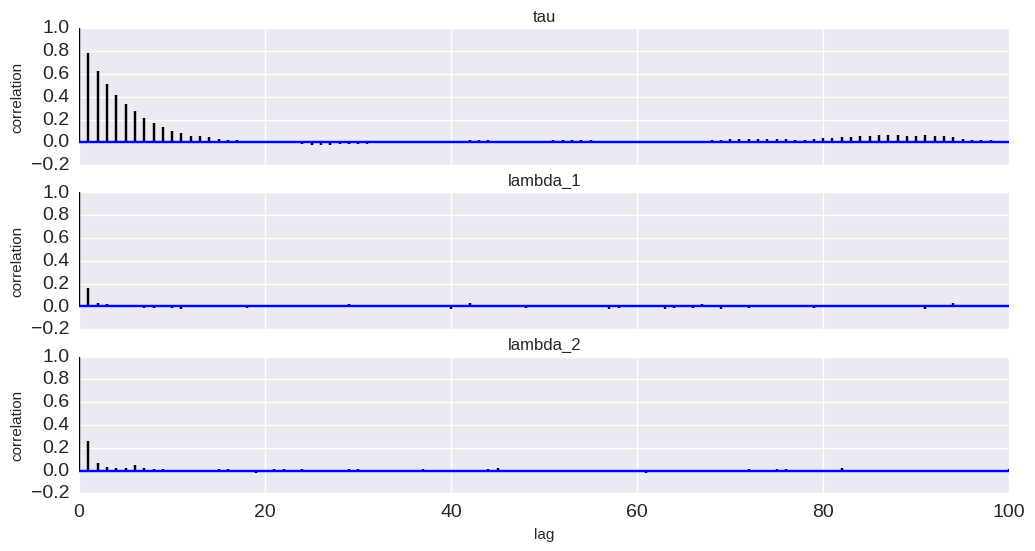

In [59]:
pm.autocorrplot(chainExpPr);

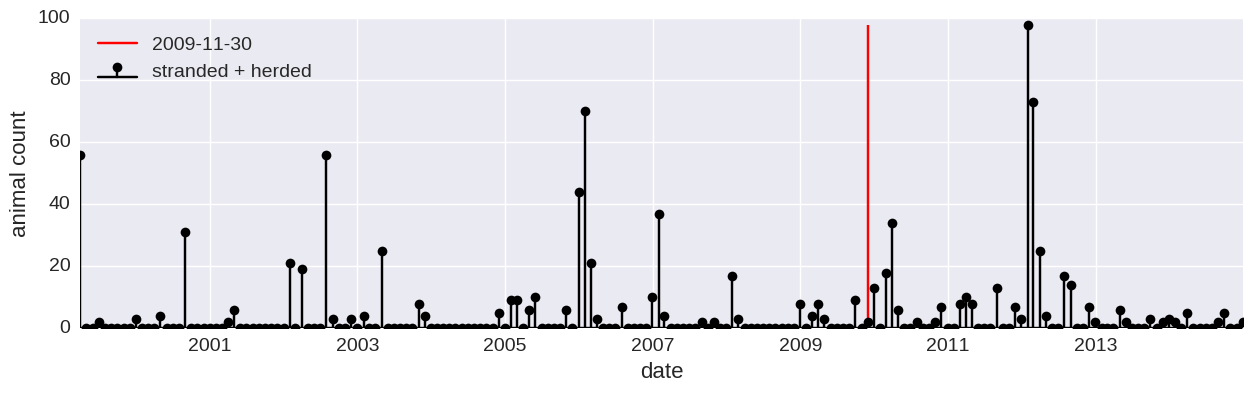

In [60]:
f,ax=pl.subplots(figsize=(15,4))
markerline, stemlines, baseline = ax.stem(dfs_monthly.index.values, dfs_monthly.total.values,
                                          label='stranded + herded')
pl.setp(markerline, 'color','k')
pl.setp(stemlines, 'color', 'k')
pl.setp(baseline, 'color', 'k')
ax.xaxis_date()
ax.vlines(dfs_monthly.index.values[128], ymin=0, ymax=dfs_monthly.total.values.max(),
         color='r',
         label='%s' % str(dfs_monthly.index.values[128]).split('T')[0])
ax.legend(loc='best', fontsize=14)
ax.set_xlabel('date', fontsize=16)
ax.set_ylabel('animal count',fontsize=16);

In [61]:
dfs_monthly.ix[:128,'total'].values.mean(), dfs_monthly.ix[128:, 'total'].values.mean()

(4.25, 6.532258064516129)

So with an exponential prior we have a switchpoint, $\tau$, around the $128^{th}$ month of the (unpadded) series, a 4.25 mean stranding rate before, and a 6.5 mean stranding rate after.
I see some spikes before that so I'll take the dataset before month 128 and see if I can identify another switchpoint.

In [62]:
data = totCntData[:128]
with pm.Model() as model:
    alpha = 1.0/totCntData[:128].mean()
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=data.size-1)
    idx = np.arange(data.size)
    lambda_ = pm.math.switch( tau >= idx, lambda_1, lambda_2 )
    lklhd = pm.Poisson("lklhd", lambda_, observed=data)
    #step = pm.Metropolis(model.free_RVs)
    traceExpPrTrunc = pm.sample(10000, tune=1000)

Assigned NUTS to lambda_1_log_
Assigned NUTS to lambda_2_log_
Assigned Metropolis to tau
100%|██████████| 10000/10000 [00:10<00:00, 934.25it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ba6da05f8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4b7b3b1438>]], dtype=object)

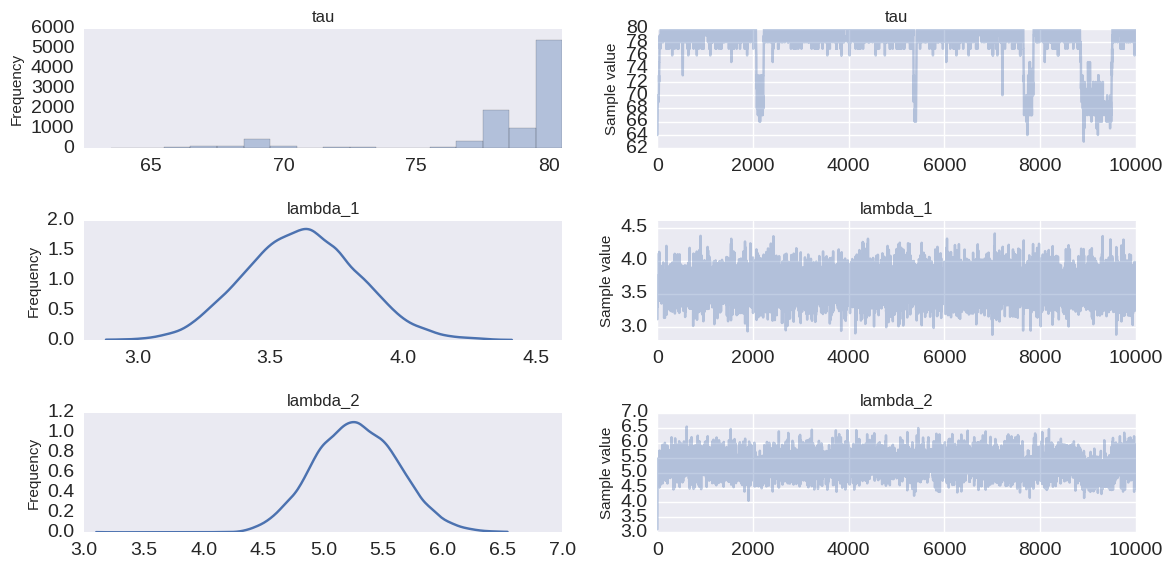

In [63]:
pm.traceplot(traceExpPrTrunc)

In [64]:
pm.df_summary(traceExpPrTrunc)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
tau,78.134600,3.430872,0.298773,69.000000,80.000000
lambda_1,3.620069,0.213513,0.002507,3.209431,4.036099
lambda_2,5.270101,0.347452,0.010759,4.596311,5.934821


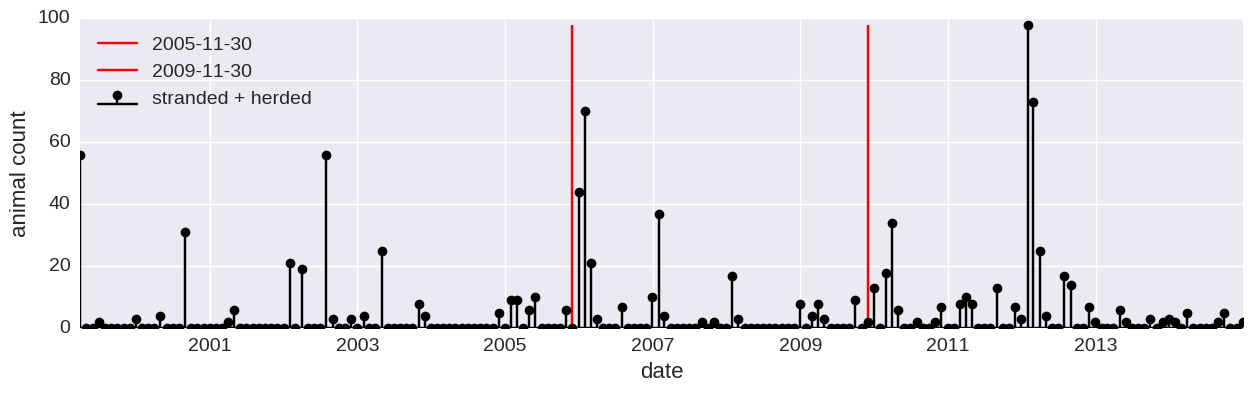

In [65]:
f,ax=pl.subplots(figsize=(15,4))
markerline, stemlines, baseline = ax.stem(dfs_monthly.index.values, dfs_monthly.total.values,
                                          label='stranded + herded')
pl.setp(markerline, 'color','k')
pl.setp(stemlines, 'color', 'k')
pl.setp(baseline, 'color', 'k')
ax.xaxis_date()
ax.vlines(dfs_monthly.index.values[80], ymin=0, ymax=dfs_monthly.total.values.max(),
         color='r',
         label='%s' % str(dfs_monthly.index.values[80]).split('T')[0])
ax.vlines(dfs_monthly.index.values[128], ymin=0, ymax=dfs_monthly.total.values.max(),
         color='r',
         label='%s' % str(dfs_monthly.index.values[128]).split('T')[0])
ax.legend(loc='best', fontsize=14)
ax.set_xlabel('date', fontsize=16)
ax.set_ylabel('animal count',fontsize=16);

In [66]:
print(dfs_monthly.ix[:80,'total'].mean())
print(dfs_monthly.ix[80:128,'total'].mean())
print(dfs_monthly.ix[128:, 'total'].mean())

3.65
5.25
6.532258064516129


In [67]:
print(dfs_monthly.index.values[79])
print(dfs_monthly.index.values[128])

2005-10-31T00:00:00.000000000
2009-11-30T00:00:00.000000000


The above then suggests the presence of a couple of switchpoints; one around the end of 2005, and one around the end of 2009. There might be more but I'm not comfortable given the data paucity to truncate the data set further. Note that I haven't 0-padded the data (introduced months with zero count into the time series. Doing so would be more realistic and might different results. I'll try that next and if it's the case, I'll revise this post accordingly.

Tentatively, we could be done with the exploration of the count data. Another feature that we might explore is whether, and if so how, the probability that an event (2 or more animals, without any significance attached to animal count) occurs shifts. A bernoulli process would be an appropriate candidate for modeling this question.